# CUSTOMER SEGMENTATION

## Predict Passenger Satisfaction

In [1]:
# Business Understanding
# Data Understanding
# Data Preparation

In [2]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import joblib

## DATA PREPARATION

In [3]:
# Create Wrangle function

def wrangle(filepath):

    # Create DataFrame from DataSet
    df = pd.read_csv(filepath)

    # Drop Unnamed: 0 column
    df.drop(columns=["Unnamed: 0"], inplace=True)

    # Drop Arrival Delay in Minutes null values rows
    df.dropna(inplace=True)

    # Drop id column as it has high cardinality thus will add no value to determining satisfaction
    df.drop(columns=["id"], inplace=True)

    # Addressing multicollinearity
    df['Total Flight Delay in Minutes'] = df['Arrival Delay in Minutes'] + df['Departure Delay in Minutes']
    df.drop(columns=['Arrival Delay in Minutes', 'Departure Delay in Minutes'], inplace=True)

    return df

In [4]:
# Wrangle DataSet

df = wrangle("train.csv")
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Total Flight Delay in Minutes
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,5,4,3,4,4,5,5,neutral or dissatisfied,43.0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,1,5,3,1,4,1,neutral or dissatisfied,7.0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,satisfied,0.0
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,2,5,3,1,4,2,neutral or dissatisfied,20.0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,5,3,3,4,4,3,3,3,satisfied,0.0


In [5]:
# Printing the shape of my dataframe

df.shape

(103594, 22)

### Data Cleaning

In [6]:
# Checking for duplicates

df.duplicated().sum()

0

In [7]:
# Checking for null values

df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
satisfaction                         0
Total Flight Delay in Minutes        0
dtype: int64

In [8]:
# Inspect Data in my DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    103594 no

### Checking for low or high cardinality

In [9]:
df.select_dtypes("number").head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Total Flight Delay in Minutes
0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,43.0
1,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,7.0
2,26,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0.0
3,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,20.0
4,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0


In [10]:
df.select_dtypes("number").nunique()

Age                                    75
Flight Distance                      3802
Inflight wifi service                   6
Departure/Arrival time convenient       6
Ease of Online booking                  6
Gate location                           6
Food and drink                          6
Online boarding                         6
Seat comfort                            6
Inflight entertainment                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Inflight service                        6
Cleanliness                             6
Total Flight Delay in Minutes         767
dtype: int64

In [11]:
df.select_dtypes("object").head()

,Gender,Customer Type,Type of Travel,Class,satisfaction
0,Male,Loyal Customer,Personal Travel,Eco Plus,neutral or dissatisfied
1,Male,disloyal Customer,Business travel,Business,neutral or dissatisfied
2,Female,Loyal Customer,Business travel,Business,satisfied
3,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
4,Male,Loyal Customer,Business travel,Business,satisfied


In [12]:
df.select_dtypes("object").nunique()

Gender            2
Customer Type     2
Type of Travel    2
Class             3
satisfaction      2
dtype: int64

## Explore

/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/muruthi/anaconda3/envs/learn-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


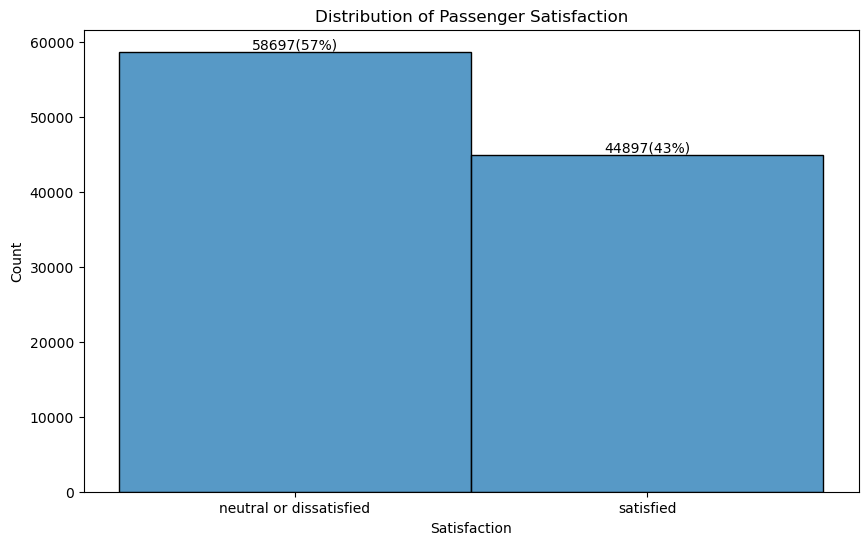

In [13]:
# since I am trying to predict passenger satisfaction. Let's visualize how satisfied the passengers are satisfied
# using histogram

# Visualize passenger satisfaction distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=df, x="satisfaction", kde=False, ax=ax)

# Add count and percentage annotations
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, 
            f"{int(height)}({height/len(df)*100:.0f}%)", 
            ha="center", va="bottom")

ax.set_xlabel("Satisfaction")
ax.set_ylabel("Count")
ax.set_title("Distribution of Passenger Satisfaction")
plt.show();

#### From the above we can see that 57% of the passengers were dissatisfied. But why?

#### Let's look at how passenger satisfaction is correlated to other features

## Encoding Categorical Features

In [14]:
# Instanciate Transformer

le = LabelEncoder()

df["satisfaction"] = le.fit_transform(df["satisfaction"])


In [15]:
# Encoding all other categorical features

df["Gender"] = le.fit_transform(df["Gender"])
df["Customer Type"] = le.fit_transform(df["Customer Type"])
df["Type of Travel"] = le.fit_transform(df["Type of Travel"])
df["Class"] = le.fit_transform(df["Class"])

In [16]:
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction,Total Flight Delay in Minutes
0,1,0,13,1,2,460,3,4,3,1,...,5,5,4,3,4,4,5,5,0,43.0
1,1,1,25,0,0,235,3,2,3,3,...,1,1,1,5,3,1,4,1,0,7.0
2,0,0,26,0,0,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,1,0.0
3,0,0,25,0,0,562,2,5,5,5,...,2,2,2,5,3,1,4,2,0,20.0
4,1,0,61,0,0,214,3,3,3,3,...,5,3,3,4,4,3,3,3,1,0.0


In [17]:
corr_satisfaction = df.corr(numeric_only=True)["satisfaction"].sort_values(ascending=False)
corr_satisfaction

satisfaction                         1.000000
Online boarding                      0.503447
Inflight entertainment               0.398203
Seat comfort                         0.349112
On-board service                     0.322450
Leg room service                     0.313182
Cleanliness                          0.305050
Flight Distance                      0.298915
Inflight wifi service                0.284163
Baggage handling                     0.247819
Inflight service                     0.244852
Checkin service                      0.235914
Food and drink                       0.209659
Ease of Online booking               0.171507
Age                                  0.137040
Gender                               0.012356
Gate location                        0.000449
Departure/Arrival time convenient   -0.051718
Total Flight Delay in Minutes       -0.054548
Customer Type                       -0.187558
Type of Travel                      -0.448995
Class                             

#### The features with the strongest positive correlations to satisfaction are:

#### - Online boarding (0.503)
#### - Inflight entertainment (0.398)
#### - Seat comfort (0.349)
#### - On-board service (0.322)

#### These would be the most important factors to focus on for improving customer satisfaction.
#### The features with moderate positive correlations include leg room service, cleanliness, flight distance, and inflight wifi service.
#### Departure/arrival time convenience and total flight delay had weak negative correlations, indicating they are less influential on satisfaction.

### Checking for and dealing with multicollinearity using a heatmap

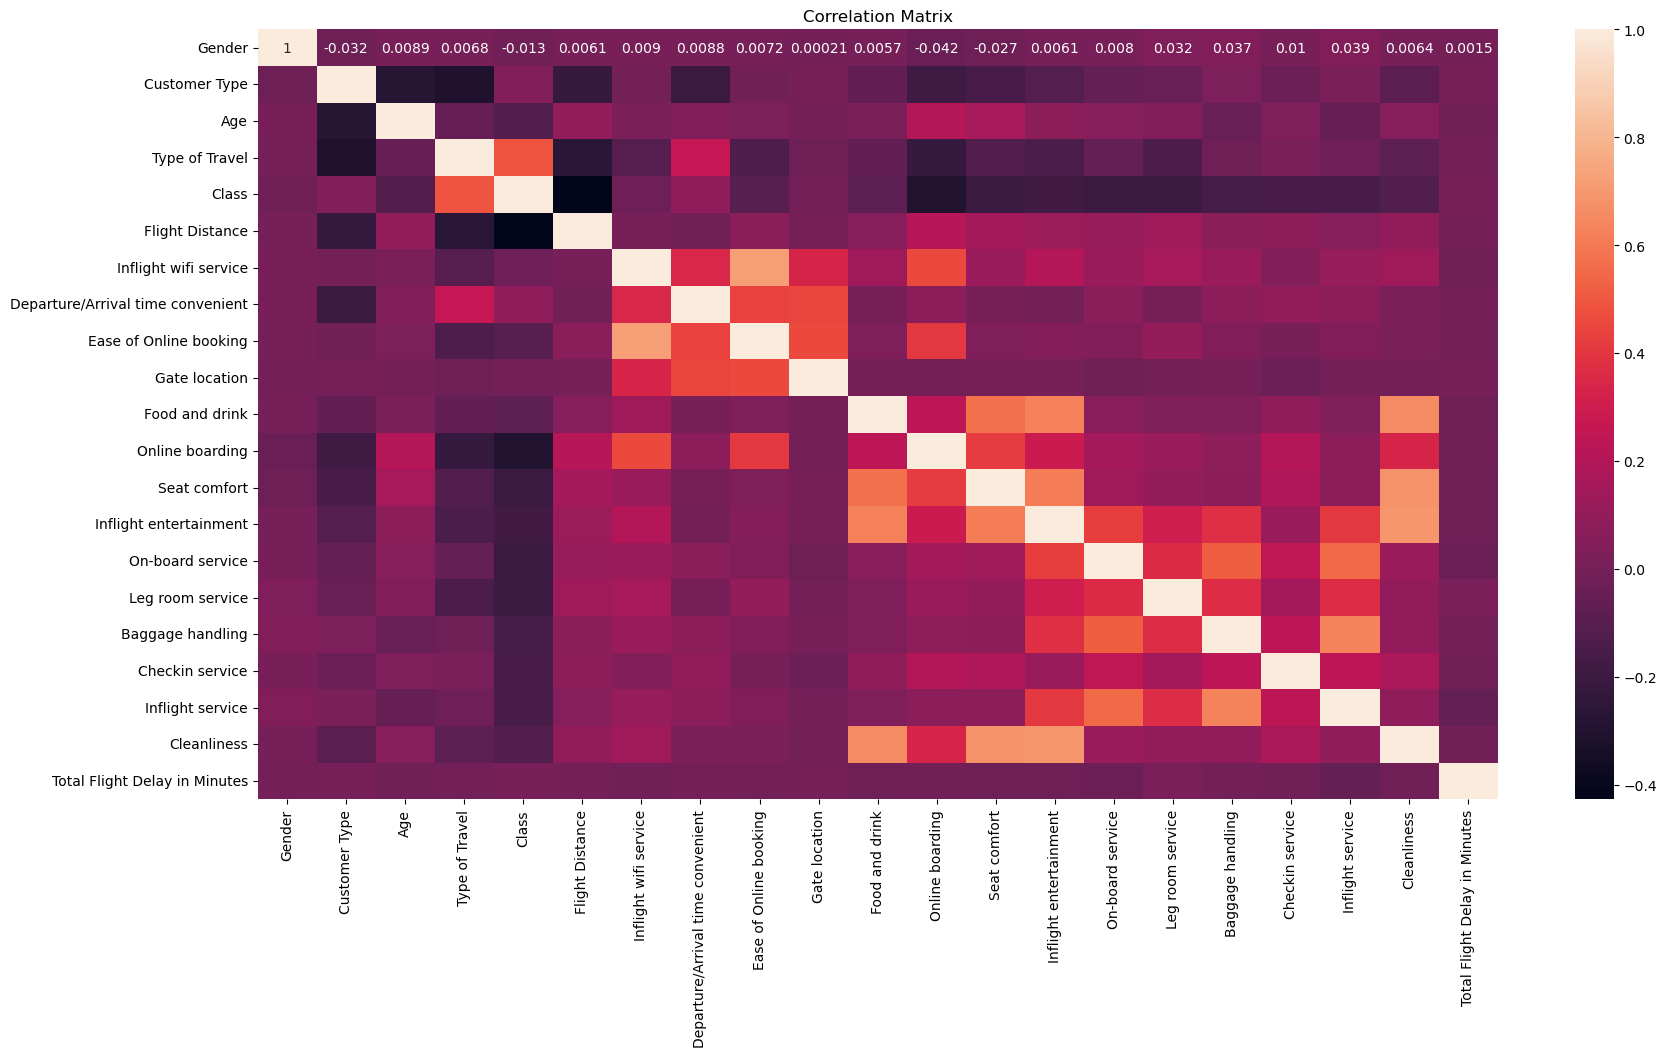

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(df.drop(columns=["satisfaction"]).corr(), annot=True)
plt.title("Correlation Matrix")
plt.show();

In [19]:
corr_matrix = df.corr()

# Identify highly correlated pairs
high_corr_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns if abs(corr_matrix[col1][col2]) > 0.7 and col1 != col2]

# Print the highly correlated pairs
for pair in high_corr_pairs:
    print(f"Highly correlated pair: {pair[0]} and {pair[1]}, correlation = {corr_matrix[pair[0]][pair[1]]:.2f}")


Highly correlated pair: Inflight wifi service and Ease of Online booking, correlation = 0.72
Highly correlated pair: Ease of Online booking and Inflight wifi service, correlation = 0.72


#### I will not drop any of the two columns Ease of Online booking and Inflight wifi service as they are essentially different

## MODELLING

In [20]:
# Define the target vector(y) and feature matrix(X)
X = df.drop(columns="satisfaction", axis=1)
y = df["satisfaction"]

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardizing The Data

In [21]:
# Initializing the Scaler
scaler = StandardScaler()

# Fitting the scaler on the training Data and Transforming it
# Ensure the scaled data has consistent structure during training and testing by Converting the scaled arrays back to pandas DataFrames with the original column names
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

#Transforming the test data using the same parameters
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### BASELINE MODEL

### Logistic Regression Model

In [22]:
# Training Baseline Model

# Create model
baseline_lr_model = LogisticRegression(random_state=42, max_iter=500)

# Fit model
baseline_lr_model.fit(X_train_scaled, y_train)

# Predict
baseline_prediction = baseline_lr_model.predict(X_test)

# Test Accuracy, precision, recall, f1 score
baseline_accuracy = accuracy_score(y_test, baseline_prediction)
baseline_precision = precision_score(y_test, baseline_prediction)
baseline_recall = recall_score(y_test, baseline_prediction)
baseline_f1_score = f1_score(y_test, baseline_prediction)

print(f"Baseline Model Accuracy: {baseline_accuracy}")
print(f"Baseline model Precision: {baseline_precision}")
print(f"Baseline Model Recall: {baseline_recall}")
print(f"Baseline F1 Score: {baseline_f1_score}");

Baseline Model Accuracy: 0.5884453882909407
Baseline model Precision: 0.6232216613125287
Baseline Model Recall: 0.1498234774933804
Baseline F1 Score: 0.24157253402116874


In [23]:
print("Classification Report")
print(classification_report(y_test, baseline_prediction));

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.93      0.72     11655
           1       0.62      0.15      0.24      9064

    accuracy                           0.59     20719
   macro avg       0.60      0.54      0.48     20719
weighted avg       0.60      0.59      0.51     20719



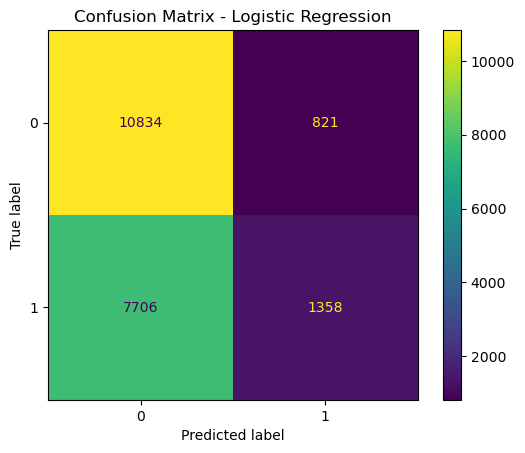

In [24]:
# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, baseline_prediction)
cm_logreg_display = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=baseline_lr_model.classes_)
cm_logreg_display.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show();

### Random Forest Model